In [48]:
# data, system tools
import pandas as pd
import numpy as np
import os
import glob
import itertools

# multiprocessing
import multiprocessing as mp
from functools import partial
import joblib

# stats
from statsmodels.stats import outliers_influence
import statsmodels.stats.multitest as multi
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statannot
import scipy
import scipy.stats
from scipy.stats import chi2

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

## Fit functions

In [60]:
possible_predictors = ['Age', 'Age2', 'sex', 'Age:sex', 'Age2:sex']
all_models = pd.DataFrame(list(itertools.product(*[[False, True] for x in range(len(possible_predictors))])), columns=possible_predictors)
# remove double interactions
all_models = all_models.loc[~((all_models['Age:sex']) & (all_models['Age2:sex']))]
all_models

,Age,Age2,sex,Age:sex,Age2:sex
0,False,False,False,False,False
1,False,False,False,False,True
2,False,False,False,True,False
4,False,False,True,False,False
5,False,False,True,False,True
6,False,False,True,True,False
8,False,True,False,False,False
9,False,True,False,False,True
10,False,True,False,True,False
12,False,True,True,False,False


In [49]:
## Fitting functions
def make_empty_model_df(ROIs,
#                         metrics=('iron', 'myelin', 'r1hz', 'r2hz', 'qsm', 'thickness'), 
#                         statistics=('median', 'iqr'), 
                        metric_statistic_combs,
                        predictors=('Age', 'Age2', 'sex', 'Age*sex', 'Age2*sex')):
    
    possible_predictors = ['Age', 'Age2', 'sex', 'Age:sex', 'Age2:sex']
    all_models = pd.DataFrame(list(itertools.product(*[[False, True] for x in range(len(possible_predictors))])), columns=possible_predictors)
    # remove double interactions
    all_models = all_models.loc[~((all_models['Age:sex']) & (all_models['Age2:sex']))]
    
    def make_iv_string(x):
        ivs = ' + '.join(np.array(x.index)[x.values])
        if ivs == '':
            ivs = '1'
        return ivs
    ivs = all_models.apply(lambda x: make_iv_string(x), axis=1).values
    
    all_combs = list(itertools.product(ROIs, metric_statistic_combs, ivs)) #metrics, statistics, ivs))
    all_combs = [(x[0], x[1][0], x[1][1], x[2]) for x in all_combs]
    model_df = pd.DataFrame(all_combs, columns=['ROI', 'qMRI', 'Statistic', 'ivs'])
    model_df['model'] = np.nan
    model_df['result'] = np.nan
    model_df['BIC'] = np.nan
    model_df['rsquared'] = np.nan
    return model_df, all_combs

def fit_mp(to_fit, model_df, data_df, 
           dep_var_name = 'Value',
           predictor_columns = ('Age', 'Age2', 'sex'),
           exclude_high_cook=False):
    
    roi, qmri, statistic, ivs = to_fit
    
    # find index of this model
    idx_modeldf = (model_df.qMRI == qmri) & (model_df.ROI == roi) & (model_df.ivs == ivs) & (model_df.Statistic == statistic)
    
    # find index of this data
    idx_datadf = (data_df.Intensity == qmri) & (data_df.ROI2 == roi) & (data_df.Statistic == statistic)
    
    # make a quick copy, for ease
    get_columns = [dep_var_name] + list(predictor_columns)
    if exclude_high_cook:
        this_df = data_df.loc[idx_datadf,  get_columns + ['high_cook']].copy()
        this_df = this_df.loc[this_df['high_cook']==False]
    else:
        this_df = data_df.loc[idx_datadf, get_columns].copy()
    
    if pd.isnull(this_df[dep_var_name]).sum() > 0:
        print('WARNING: {} {} {} has missing values'.format(roi, qmri, statistic))
    this_df = this_df.loc[~pd.isnull(this_df[dep_var_name])]
    
    # fit
    formula = dep_var_name + ' ~ ' + ivs
    model = smf.ols(formula, this_df)
    results = model.fit()
    
    # fit quality
    model_df.loc[idx_modeldf, 'model'] = model
    model_df.loc[idx_modeldf, 'result'] = results
    model_df.loc[idx_modeldf, 'BIC'] = results.bic
    model_df.loc[idx_modeldf, 'rsquared'] = results.rsquared
    
#     # Bayesian fitting in R
#     if ivs != '1':
#         bf_obj = bayesfactor.lmBF(ro.r('as.formula(' + formula + ')'), data=this_df)
#         model_df.loc[idx_modeldf, 'bf'] = bayesfactor.extractBF(bf_obj)['bf'].values[0]    
    
    return model_df.loc[idx_modeldf]

## Plot functions

In [50]:
def plot_influence(df, winning_model_df, influence_type='index', 
                   f=None, ax=None, shape=(4,4)):
    if ax is None:
        f, ax = plt.subplots(shape[0], shape[1], sharey=True)
        ax = ax.ravel()
        
    for i, roi in enumerate(df.ROI.unique()):
        # plot winning model
        model_df_idx = (winning_model_df.ROI == roi) #& (winning_model_df.qMRI == intensity) & (winning_model_df.Statistic == statistic)
        if model_df_idx.sum() > 0:
            result = winning_model_df.loc[model_df_idx, 'result'].values[0]
            if influence_type == 'index':
                _ = outliers_influence.OLSInfluence(result).plot_index(ax=ax[i], title=roi)
            elif influence_type == 'influence':
                _ = outliers_influence.OLSInfluence(result).plot_influence(ax=ax[i], title=roi)
    f.set_size_inches(15, 15)
    f.tight_layout()
    f.subplots_adjust(top=0.95, right=.9)
    return f, ax

def plot_residuals(df, winning_model_df, model_df, studentized=False,
                         f=None, ax=None, shape=(4,4)):
    if ax is None:
        f, ax = plt.subplots(shape[0], shape[1], sharey=True)
        ax = ax.ravel()
        
    for i, roi in enumerate(df.ROI.unique()):
        # plot winning model
        ax[i].axhline(0)
        ax[i].set_xlabel('Age')
        ax[i].set_ylabel('Residual')
        ax[i].set_title(roi)

        model_df_idx = (winning_model_df.ROI == roi) #& (winning_model_df.qMRI == intensity) & (winning_model_df.Statistic == statistic)
        if model_df_idx.sum() > 0:
            result = winning_model_df.loc[model_df_idx, 'result'].values[0]
            if studentized:
                y_vals = outliers_influence.OLSInfluence(result).resid_studentized
            else:
                y_vals = outliers_influence.OLSInfluence(result).resid
            
            # look up corresponding age values. If the *winning* model doesn't have age as a predictor, 
            # look ages up from a (non-winning) model that does have age
            if 'Age' in result._results.model.data.orig_exog.columns:
                x_vals = result._results.model.data.orig_exog['Age']
            else:
                model_df_idx2 = (model_df.ROI == roi) & (model_df.ivs == 'Age') #& (model_df.qMRI == intensity) & (model_df.Statistic == statistic) & (model_df.ivs == 'Age')
                result_with_age = model_df.loc[model_df_idx2, 'result'].values[0]
                x_vals = result_with_age._results.model.data.orig_exog['Age']
            
            # plot
            _ = ax[i].plot(x_vals, y_vals, '.')

    f.set_size_inches(15, 15)
    f.tight_layout()
    f.subplots_adjust(top=0.95, right=.9)

def plot_model_fit(df, winning_model_df, statistic='', intensity='', f=None, ax=None, shape=(4,4),
                   dep_var_name='Value'):
    if ax is None:
        f, ax = plt.subplots(shape[0], shape[1], sharey=True)
        ax = ax.ravel()
    
    age_range = np.arange(19, 81)
    predict_df_0 = pd.DataFrame({'Age': age_range, 'Age2': age_range**2, 'sex': 0})
    predict_df_1 = pd.DataFrame({'Age': age_range, 'Age2': age_range**2, 'sex': 1})
    
    for i, roi in enumerate(df.ROI.unique()):
        idx = (df.ROI == roi) & (df.Intensity == intensity) & (df.Statistic == statistic)

        this_df = df.loc[idx, [dep_var_name] + ['Age', 'Age2', 'sex']]
#        this_df['is_outlier'] = 0
        if 'high_cook' in df.columns:
            this_df['is_outlier'] = df.loc[idx, 'high_cook'].values.copy().astype(int)
        else:
            this_df['is_outlier'] = 0
        ax[i].axhline(y=0, linestyle='--', color='black')

        ## non-outliers
        ax[i].plot(this_df.loc[(idx) & (this_df['sex']==0) & (this_df['is_outlier']==0), 'Age'], this_df.loc[(idx) & (this_df['sex']==0) & (this_df['is_outlier']==0), dep_var_name], '.', c='red', label='F data')
        ax[i].plot(this_df.loc[(idx) & (this_df['sex']==1) & (this_df['is_outlier']==0), 'Age'], this_df.loc[(idx) & (this_df['sex']==1) & (this_df['is_outlier']==0), dep_var_name], '.', c='blue', label='M data')

        ## outliers
        ax[i].plot(this_df.loc[(idx) & (this_df['sex']==0) & (this_df['is_outlier']==1), 'Age'], this_df.loc[(idx) & (this_df['sex']==0) & (this_df['is_outlier']==1), dep_var_name], 'x', c='red', label='F outlier')
        ax[i].plot(this_df.loc[(idx) & (this_df['sex']==1) & (this_df['is_outlier']==1), 'Age'], this_df.loc[(idx) & (this_df['sex']==1) & (this_df['is_outlier']==1), dep_var_name], 'x', c='blue', label='M outlier')
        ax[i].set_ylabel(intensity)
        ax[i].set_xlabel('Age')
        ax[i].set_title(roi)

        # plot winning model
        model_df_idx = (winning_model_df.ROI == roi) & (winning_model_df.qMRI == intensity) & (winning_model_df.Statistic == statistic)
        if model_df_idx.sum() > 0:
            result = winning_model_df.loc[model_df_idx, 'result'].values[0]

            predicted_0 = result.predict(predict_df_0) # sex = 0
            predicted_1 = result.predict(predict_df_1) # sex = 1

            ax[i].plot(age_range, predicted_0, '-', label='F model', c='red')
            ax[i].plot(age_range, predicted_1, '-', label='M model', c='blue')

            # add text indicating the winning model. Apply a "trick" plot an empty line with the winning model as the label
            tmp = ax[i].plot(np.NaN, np.NaN, '-', color='none', label=winning_model_df.loc[model_df_idx, 'ivs'].values[0])
            handles, labels = ax[i].get_legend_handles_labels()
            ax[i].legend(handles[-1:], labels[-1:])

    # add a legend
    handles, labels = ax[i].get_legend_handles_labels()
    f.legend(handles[:-1], labels[:-1], loc='right')   # skip first (dots) and last (label) index
    f.suptitle('{} {}'.format(statistic, intensity), fontsize=24)
            
    # add shared axis labels
    f.add_subplot(111, frame_on=False)
    plt.tick_params(labelcolor="none", bottom=False, left=False)
    plt.xlabel("Age")

    # increase size, tight layout so labels dont overlap, add some space at the top & left so title fits
    f.set_size_inches(15, 15)
    f.tight_layout()
    f.subplots_adjust(top=0.95, right=.9)

    return f, ax

# plot_model_fit(df.loc[(df.Intensity == 'iron') & (df.Statistic == 'median')],
#                winning_model_df.loc[(winning_model_df.qMRI == 'iron') & (winning_model_df.Statistic == 'median')],
#                intensity='iron', statistic='median')

# plot_residuals(df.loc[(df.Intensity == 'iron') & (df.Statistic == 'median')],
#                winning_model_df.loc[(winning_model_df.qMRI == 'iron') & (winning_model_df.Statistic == 'median')],
#                model_df.loc[(model_df.qMRI == 'iron') & (model_df.Statistic == 'median')],
#                intensity='iron', statistic='median', studentized=True)

def make_plot_mp(combination, df, winning_model_df, model_df, dep_var_name='Value',
                 fn_template='./figures_quadratic/modality-{}_statistic-{}.pdf'):
    intensity, statistic = combination
    print(intensity)
    
    pdf = PdfPages(fn_template.format(intensity, statistic))
    f, ax = plt.subplots(5,4, sharey=intensity != 'volume')  # for volume estimates, don't share y because the variability is too large
    ax = ax.ravel()

    # select from dataframes
    this_df = df.loc[(df.Intensity == intensity) & (df.Statistic == statistic)]
    this_winning_model_df = winning_model_df.loc[(winning_model_df.qMRI == intensity) & (winning_model_df.Statistic == statistic)]
    this_model_df = model_df.loc[(model_df.qMRI == intensity) & (model_df.Statistic == statistic)]

    plot_model_fit(df=this_df,
                   winning_model_df=this_winning_model_df, dep_var_name=dep_var_name,
                   intensity=intensity, statistic=statistic, f=f, ax=ax)
    pdf.savefig(f)

    for plot_type in ['index', 'influence']:
        f, ax = plt.subplots(5,4, sharey=True)
        ax = ax.ravel()
        plot_influence(df=this_df, winning_model_df=this_winning_model_df, influence_type=plot_type, f=f, ax=ax)
        pdf.savefig(f)

    for studentized in [False, True]:
        f, ax = plt.subplots(5,4, sharey=True)
        ax = ax.ravel()
        plot_residuals(df=this_df, 
                       winning_model_df=this_winning_model_df, 
                       model_df=this_model_df, studentized=studentized,
                       f=f, ax=ax)
        pdf.savefig(f)

    pdf.close()
    plt.close('all')  ## force close, don't show in-line

In [51]:
ahead_long = pd.read_csv('../data/final_data/AHEAD_and_CRUISE_and_ICV-combined-long.csv')
ahead_long['Statistic'] = ahead_long['Measure'].apply(lambda x: x.lower().split('_')[0])

#### let's pretend FX & cerebellum are left hemisphere - makes plotting a bit easier
ahead_long.loc[ahead_long['ROI'] == 'fx', 'hemisphere'] = 'L'
ahead_long.loc[ahead_long['ROI'] == 'Cerebellum', 'hemisphere'] = 'L'

ahead_long.Intensity = ahead_long.Intensity.replace({'seg': 'volume'})
# ahead_long.Measure = ahead_long.Measure.replace({'Volume': 'voxels'})
# ahead_long.Statistic = ahead_long.Statistic.replace({'volume': 'voxels'})

ahead_long.head()

,Intensity,Measure,Segmentation,Age,Sexe,icv,ROI,Value,ROI2,hemisphere,tissue_type,Statistic
0,location,CenterOfMassX,sub-000,22.0,f,1408505.6,STR L,155.075760,STR,L,GM,centerofmassx
1,location,CenterOfMassY,sub-000,22.0,f,1408505.6,STR L,185.431760,STR,L,GM,centerofmassy
2,location,CenterOfMassZ,sub-000,22.0,f,1408505.6,STR L,152.403210,STR,L,GM,centerofmassz
3,iron,IQR_intensity,sub-000,22.0,f,1408505.6,STR L,3.993294,STR,L,GM,iqr
4,myelin,IQR_intensity,sub-000,22.0,f,1408505.6,STR L,2.239665,STR,L,GM,iqr


In [52]:
# ahead_long = ahead_long.loc[~((ahead_long['Intensity'] == 'seg') & (ahead_long['Measure'] == 'Volume'))]
# ahead_long = ahead_long.loc[~((ahead_long['Intensity'] == 'seg') & (ahead_long['Measure'] == 'Median_intensity'))]

# ahead_long.loc[(ahead_long['Intensity'] == 'seg') & (ahead_long['Measure'] == 'Voxels'), 'Value'] *= (0.75**3)
# ahead_long['Measure'] = ahead_long['Measure'].replace({'Voxels': 'Median_intensity'}) ## = volume!
# ahead_long['Statistic'] = ahead_long['Statistic'].replace({'voxels': 'median'}) ## = volume!

In [53]:
# ahead_long['Measure'] = ahead_long['Measure'].replace({'Volume': 'Median_intensity'})  # for ease

#### Reformat data

Get rid of all measures that are not median or IQR

In [54]:
qMRI_data = ahead_long.loc[(ahead_long.Intensity.isin(['iron', 'myelin', 'r1hz', 'r2hz', 'qsm', 'qpd', 'thickness', 'volume'])) & (ahead_long.Measure.isin(['Median_intensity', 'IQR_intensity', 'Voxels', 'Volume']))]#'IQR_relative_to_median']))]
qMRI_data.head()

,Intensity,Measure,Segmentation,Age,Sexe,icv,ROI,Value,ROI2,hemisphere,tissue_type,Statistic
3,iron,IQR_intensity,sub-000,22.0,f,1408505.6,STR L,3.993294,STR,L,GM,iqr
4,myelin,IQR_intensity,sub-000,22.0,f,1408505.6,STR L,2.239665,STR,L,GM,iqr
5,qpd,IQR_intensity,sub-000,22.0,f,1408505.6,STR L,0.214799,STR,L,GM,iqr
6,qsm,IQR_intensity,sub-000,22.0,f,1408505.6,STR L,0.026030,STR,L,GM,iqr
7,r1hz,IQR_intensity,sub-000,22.0,f,1408505.6,STR L,0.077003,STR,L,GM,iqr


In [55]:
def get_difference(x):
    is_left = x['hemisphere']=='L'
    return pd.DataFrame({'Segmentation': x.loc[is_left, 'Segmentation'].values,
                         'Age': x.loc[is_left, 'Age'].values,
                         'Sexe': x.loc[is_left, 'Sexe'].values,
                         'icv': x.loc[is_left, 'icv'].values,
                         'Difference': x.loc[x['hemisphere']=='L','Value'].values - x.loc[x['hemisphere']=='R','Value'].values})

qMRI_data_2hemispheres = qMRI_data.loc[qMRI_data['ROI'].apply(lambda x: x.endswith(' R') or x.endswith(' L'))]    
inter_hemisphere_differences = qMRI_data_2hemispheres.groupby(['Intensity', 'Statistic', 'ROI2']).apply(lambda x: get_difference(x)).reset_index()

# tmp = inter_hemisphere_differences.loc[inter_hemisphere_differences.Intensity.isin(['iron', 'myelin', 'thickness'])]
# tmp['ROI'] = tmp['ROI2']
# tmp['ROI'] = tmp['ROI'].replace({'Cortex': 'Ctx'})

## 1. Test for changes over time in interhemisphere differences

In [56]:
inter_hemisphere_differences['sex'] = (inter_hemisphere_differences['Sexe'] == 'm').astype(int)
inter_hemisphere_differences['Age2'] = inter_hemisphere_differences['Age']**2
inter_hemisphere_differences.head()

# drop cortex for now
inter_hemisphere_differences = inter_hemisphere_differences.loc[inter_hemisphere_differences.ROI2 != 'Cortex']

In [57]:
def make_all_combinations(metrics=('iron', 'myelin', 'r1hz', 'r2hz', 'qsm', 'qpd', 'thickness'), statistics=('median', 'iqr'), to_append=[('volume', 'voxels'), ('volume', 'volume')]):
    return list(itertools.product(metrics, statistics)) + to_append

In [11]:
model_df, all_combinations = make_empty_model_df(ROIs=inter_hemisphere_differences.ROI2.unique(), metric_statistic_combs=make_all_combinations()) #make_empty_model_df(ROIs=inter_hemisphere_differences.ROI2.unique(), metrics=('r1hz', 'r2hz', 'qsm', 'qpd', 'thickness'))

n_cores = 20
# with mp.Pool(n_cores) as p:
#     print("Fitting all models with {} cores".format(n_cores))
#     output = p.map(partial(fit_mp, model_df=model_df.copy(), data_df=inter_hemisphere_differences.copy(),
#                            dep_var_name='Difference', predictor_columns=('Age', 'Age2', 'sex')), all_combinations)
output = joblib.Parallel(n_jobs=n_cores, verbose=True)(joblib.delayed(fit_mp)(combination, model_df=model_df.copy(), data_df=inter_hemisphere_differences.copy(),
                                                                              dep_var_name='Difference', predictor_columns=('Age', 'Age2', 'sex')) for combination in all_combinations)

model_df = pd.concat(output)
model_df['is_winner_BIC'] = model_df.groupby(['ROI', 'qMRI', 'Statistic'])[['BIC']].apply(lambda x: x == x.min())
model_df['delta_BIC'] = model_df.groupby(['ROI', 'qMRI', 'Statistic'])[['BIC']].apply(lambda x: x-x.min())
model_df['delta_BIC_1'] = model_df.groupby(['ROI', 'qMRI', 'Statistic'])[['BIC']].apply(lambda x: x-np.sort(x['BIC'].values)[1])
model_df['delta_BIC_2'] = model_df.groupby(['ROI', 'qMRI', 'Statistic'])[['BIC']].apply(lambda x: x-np.sort(x['BIC'].values)[2])

#model_df['is_winner_bf'] = model_df.groupby(['ROI', 'qMRI', 'Statistic'])[['bf']].apply(lambda x: x == x.max())
winning_model_df = model_df.loc[model_df['is_winner_BIC']]
display(winning_model_df.groupby(['qMRI', 'Statistic'])['ivs'].value_counts())

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.3s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:   10.1s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:   17.6s
[Parallel(n_jobs=20)]: Done 1210 tasks      | elapsed:   27.2s
[Parallel(n_jobs=20)]: Done 1760 tasks      | elapsed:   38.8s
[Parallel(n_jobs=20)]: Done 2410 tasks      | elapsed:   52.6s
[Parallel(n_jobs=20)]: Done 3160 tasks      | elapsed:  1.1min
[Parallel(n_jobs=20)]: Done 4010 tasks      | elapsed:  1.4min
[Parallel(n_jobs=20)]: Done 4960 tasks      | elapsed:  1.8min
[Parallel(n_jobs=20)]: Done 5376 out of 5376 | elapsed:  1.9min finished


qMRI    Statistic  ivs           
iron    iqr        1                 11
                   Age2:sex           2
                   sex                1
        median     1                 10
                   Age                1
                                     ..
volume  voxels     Age2               1
                   Age2 + sex         1
                   Age:sex            1
                   sex                1
                   sex + Age2:sex     1
Name: ivs, Length: 65, dtype: int64

#### 1.1 Plot winning models (interhemisphere changes)

In [12]:
# plot & save
sns.set_context('notebook')

with mp.Pool(15) as p:
    p.map(partial(make_plot_mp, df=inter_hemisphere_differences.rename(columns={'ROI2': 'ROI'}).copy(), 
                  winning_model_df=winning_model_df, model_df=model_df, dep_var_name='Difference',
                  fn_template='../figures_quadratic/between-hemisphere_modality-{}_statistic-{}.pdf'), 
#          list(itertools.product(('iron', 'myelin', 'r1hz', 'r2hz', 'qsm', 'thickness'), ('median', 'iqr'))))
#           list(itertools.product(('r1hz', 'r2hz', 'qsm', 'thickness'), ('median', 'iqr'))))
          make_all_combinations())

iron
iron
myelin
myelin
r1hz
r1hz
r2hz
r2hz
qsm
qsm
qpd
qpd
thickness
thickness
volume
volume


## 1.2 Refit, with observations with high Cook's distance removed
Interhemisphere

In [13]:
winning_model_df['outlier_influence'] = winning_model_df['result'].apply(lambda x: outliers_influence.OLSInfluence(x))

inter_hemisphere_differences['cooks_d'] = winning_model_df['outlier_influence'].apply(lambda x: x.cooks_distance[0]).sum()
inter_hemisphere_differences['high_cook'] = inter_hemisphere_differences['cooks_d'] > 0.2

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [14]:
#model_df, all_combinations = make_empty_model_df(ROIs=inter_hemisphere_differences.ROI2.unique(), metrics=('r1hz', 'r2hz', 'qsm', 'qpd', 'thickness'))
model_df, all_combinations = make_empty_model_df(ROIs=inter_hemisphere_differences.ROI2.unique(), metric_statistic_combs=make_all_combinations())

n_cores = 20
with mp.Pool(n_cores) as p:
    print("Fitting all models with {} cores".format(n_cores))
    output = p.map(partial(fit_mp, model_df=model_df.copy(), data_df=inter_hemisphere_differences.copy(),
                           dep_var_name='Difference', predictor_columns=('Age', 'Age2', 'sex'), 
                           exclude_high_cook=True), all_combinations)
    
model_df = pd.concat(output)

model_df['is_winner_BIC'] = model_df.groupby(['ROI', 'qMRI', 'Statistic'])[['BIC']].apply(lambda x: x == x.min())
model_df['delta_BIC'] = model_df.groupby(['ROI', 'qMRI', 'Statistic'])[['BIC']].apply(lambda x: x-x.min())
model_df['delta_BIC_1'] = model_df.groupby(['ROI', 'qMRI', 'Statistic'])[['BIC']].apply(lambda x: x-np.sort(x['BIC'].values)[1])
model_df['delta_BIC_2'] = model_df.groupby(['ROI', 'qMRI', 'Statistic'])[['BIC']].apply(lambda x: x-np.sort(x['BIC'].values)[2])

#model_df['is_winner_bf'] = model_df.groupby(['ROI', 'qMRI', 'Statistic'])[['bf']].apply(lambda x: x == x.max())
winning_model_df = model_df.loc[model_df['is_winner_BIC']]
display(winning_model_df.groupby(['qMRI', 'Statistic'])['ivs'].value_counts())

Fitting all models with 20 cores


qMRI    Statistic  ivs           
iron    iqr        1                 12
                   Age:sex            1
                   sex                1
        median     1                 10
                   Age                1
                                     ..
volume  voxels     sex                2
                   Age                1
                   Age2               1
                   Age2 + sex         1
                   sex + Age2:sex     1
Name: ivs, Length: 61, dtype: int64

In [15]:
# plot & save
sns.set_context('notebook')

with mp.Pool(15) as p:
    p.map(partial(make_plot_mp, df=inter_hemisphere_differences.copy().rename(columns={'ROI2':'ROI'}), winning_model_df=winning_model_df, 
                  model_df=model_df, dep_var_name='Difference',
                 fn_template='../figures_quadratic/between-hemisphere_modality-{}_statistic-{}_excl-high-cooks.pdf'), 
#          list(itertools.product(('iron', 'myelin', 'r1hz', 'r2hz', 'qsm', 'thickness'), ('median', 'iqr'))))
#           list(itertools.product(('r1hz', 'r2hz', 'qsm', 'thickness'), ('median', 'iqr'))))
          make_all_combinations())

iron
iron
myelin
myelin
r1hz
r1hz
r2hz
r2hz
qsm
qsm
qpd
qpd
thickness
thickness
volume
volume


In [16]:
# # plot & save
# sns.set_context('notebook')
# df = inter_hemisphere_differences.copy()
# df['ROI'] = df['ROI2']
# df['Value'] = df['Difference']

# for intensity in ['iron', 'myelin', 'r1hz', 'r2hz', 'qsm', 'thickness']:
#     for statistic in statistics:
#         print(intensity)
#         pdf = PdfPages('./figures_quadratic/between-hemisphere_modality-{}_statistic-{}_excl-high-cooks.pdf'.format(intensity, statistic))
#         f, ax = plt.subplots(4,4, sharey=True)
#         ax = ax.ravel()
        
#         # select from dataframes
#         this_df = df.loc[(df.Intensity == intensity) & (df.Statistic == statistic)]
#         this_winning_model_df = winning_model_df.loc[(winning_model_df.qMRI == intensity) & (winning_model_df.Statistic == statistic)]
#         this_model_df = model_df.loc[(model_df.qMRI == intensity) & (model_df.Statistic == statistic)]
        
#         plot_model_fit(df=this_df,
#                        winning_model_df=this_winning_model_df,
#                        intensity=intensity, statistic=statistic, f=f, ax=ax)
#         pdf.savefig(f)
        
#         for plot_type in ['index', 'influence']:
#             f, ax = plt.subplots(4,4, sharey=True)
#             ax = ax.ravel()
#             plot_influence(df=this_df, winning_model_df=this_winning_model_df, influence_type=plot_type, f=f, ax=ax)
#             pdf.savefig(f)

#         for studentized in [False, True]:
#             f, ax = plt.subplots(4,4, sharey=True)
#             ax = ax.ravel()
#             plot_residuals(df=this_df, 
#                            winning_model_df=this_winning_model_df, 
#                            model_df=this_model_df, studentized=studentized,
#                            f=f, ax=ax)
#             pdf.savefig(f)
    
#         pdf.close()
#         plt.close('all')  ## force close, don't show in-line

# 2. Fit polynomial models Iron/Myelin ~ Age
Collapse across left/right hemisphere

In [43]:
qMRI_data_collapsed = qMRI_data.loc[~qMRI_data.ROI2.isin(['Cortex', 'Cerebellum'])].copy()
qMRI_data_collapsed['sex'] = (qMRI_data_collapsed['Sexe'] == 'm').astype(int)
qMRI_data_collapsed = qMRI_data_collapsed.groupby(['Measure', 'Segmentation', 'Age', 'icv', 'sex', 'Statistic', 'ROI2', 'Intensity'])['Value'].mean().reset_index()
qMRI_data_collapsed['ROI'] = qMRI_data_collapsed['ROI2']
qMRI_data_collapsed['Age2'] = qMRI_data_collapsed['Age']**2

In [44]:
# model_df, all_combinations = make_empty_model_df(ROIs=qMRI_data_collapsed.ROI2.unique(), metrics=('iron', 'myelin', 'r1hz', 'r2hz', 'qsm', 'thickness', 'seg'))
# all_combinations = [(roi, intensity, measure, model) for (roi, intensity, measure, model) in all_combinations if (intensity == 'seg' and measure == 'median')]
# # all_combinations

In [45]:
model_df, all_combinations = make_empty_model_df(ROIs=qMRI_data_collapsed.ROI2.unique(), metric_statistic_combs=make_all_combinations()) #metrics=('r1hz', 'r2hz', 'qsm', 'qpd', 'thickness'))

n_cores = 20
with mp.Pool(n_cores) as p:
    print("Fitting all models with {} cores".format(n_cores))
    output = p.map(partial(fit_mp, model_df=model_df.copy(), data_df=qMRI_data_collapsed.copy()), all_combinations)
    
model_df = pd.concat(output)
model_df.head()

model_df['is_winner_BIC'] = model_df.groupby(['ROI', 'qMRI', 'Statistic'])[['BIC']].apply(lambda x: x == x.min())
winning_model_df = model_df.loc[model_df['is_winner_BIC']]
display(winning_model_df.groupby(['qMRI', 'Statistic'])['ivs'].value_counts())

Fitting all models with 20 cores


qMRI    Statistic  ivs            
iron    iqr        Age                6
                   Age2 + Age2:sex    3
                   Age + Age2         2
                   Age2               2
                   sex + Age:sex      2
                                     ..
volume  voxels     Age2               1
                   Age2 + Age2:sex    1
                   Age2 + sex         1
                   Age2:sex           1
                   Age:sex            1
Name: ivs, Length: 121, dtype: int64

## 2.1 Plot winning models (Myelin/Iron ~ Age)

In [20]:
# plot & save
sns.set_context('notebook')

with mp.Pool(13) as p:
    p.map(partial(make_plot_mp, df=qMRI_data_collapsed.copy(), winning_model_df=winning_model_df, model_df=model_df,
                 fn_template='../figures_quadratic/modality-{}_statistic-{}.pdf'), 
#          list(itertools.product(('iron', 'myelin', 'r1hz', 'r2hz', 'qsm', 'thickness'), ('median', 'iqr'))))
          make_all_combinations()) # list(itertools.product(('r1hz', 'r2hz', 'qsm', 'thickness'), ('median', 'iqr'))))

iron
iron
myelin
myelin
r1hz
r1hz
r2hz
qsm
r2hz
qpd
qsm
qpd
thickness
thickness
volume
volume


## 2.2 Again, remove Cook's, Mahalanobis

In [61]:
def mahalanobis(x=None, data=None, cov=None):
    x_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left = np.dot(x_mu, inv_covmat)
    mahal = np.dot(left, x_mu.T)
    return pd.DataFrame(data={'mahalanobis_d': mahal.diagonal(),
                              'mahalanobis_p': 1-chi2.cdf(mahal.diagonal(), 1)}, index=x.index)  # chi-square distribution

out = qMRI_data_collapsed.groupby(['ROI', 'Intensity', 'Statistic']).apply(lambda x: mahalanobis(x[['Age', 'Value']], data=x[['Age', 'Value']]))
qMRI_data_collapsed['mahalanobis_d'] = out['mahalanobis_d']
qMRI_data_collapsed['mahalanobis_p'] = out['mahalanobis_p']
qMRI_data_collapsed['mahalanobis_exclude'] = qMRI_data_collapsed['mahalanobis_p'] < 0.001

In [47]:
for i in range(4):  # 4 is arbitrary, but sufficient to identify all outliers
    # find Cook's distances per subject
    winning_model_df['outlier_influence'] = winning_model_df['result'].apply(lambda x: outliers_influence.OLSInfluence(x))    
    qMRI_data_collapsed[f'cooks_d_{i}'] = winning_model_df['outlier_influence'].apply(lambda x: x.cooks_distance[0]).sum()
    # 
        
    if (qMRI_data_collapsed[f'cooks_d_{i}'] > 0.2).sum() == 0:  #no more outliers anywhere, we can stop
        break
    
    if i == 0:
        # Remove high cook's
        qMRI_data_collapsed[f'remove_{i}'] = qMRI_data_collapsed[f'cooks_d_{i}'].copy() > 0.2
    else:
        idx = pd.isnull(qMRI_data_collapsed[f'cooks_d_{i}'])
        qMRI_data_collapsed.loc[idx, f'cooks_d_{i}'] = qMRI_data_collapsed.loc[idx, f'cooks_d_{i-1}']  # null values (ie observation not in current model)? -> use previous value
        # Did removing the subs with high cook's change the winning model?
        # yes? -> keep removing them. No? -> don't remove them.
        for indx, row_ in winning_model_df.iterrows():
            if not row_[f'new_winning_model_{i-1}']:
                idx = (qMRI_data_collapsed.Intensity == row_['qMRI']) & (qMRI_data_collapsed.Statistic == row_['Statistic']) & (qMRI_data_collapsed.ROI2 == row_['ROI'])
                if i == 1:
                    # if this is the first update, set it to false
                    qMRI_data_collapsed.loc[idx, f'remove_{i-1}'] = False
                else:
                    # else, set it to whatever it was before on the previous iteration
                    qMRI_data_collapsed.loc[idx, f'remove_{i-1}'] = qMRI_data_collapsed.loc[idx, f'remove_{i-2}'].copy()

        # remove this iteration if it was remove on previous iteration OR if the subject has a high cook's on this iteration
        qMRI_data_collapsed[f'remove_{i}'] = qMRI_data_collapsed[f'remove_{i-1}'].copy() | (qMRI_data_collapsed[f'cooks_d_{i}'].copy() > 0.2)
    
    # Mark for removal
    qMRI_data_collapsed['high_cook'] = qMRI_data_collapsed[f'remove_{i}'].copy() | qMRI_data_collapsed['mahalanobis_exclude']
    
    # Fit again
    model_df, all_combinations = make_empty_model_df(ROIs=qMRI_data_collapsed.ROI2.unique(), metric_statistic_combs=make_all_combinations())
    output = joblib.Parallel(n_jobs=20, pre_dispatch='10*n_jobs', verbose=True)(joblib.delayed(fit_mp)(combination, model_df=model_df.copy(), data_df=qMRI_data_collapsed.copy(),
                                                                                                       exclude_high_cook=True) for combination in all_combinations)

#     with mp.Pool(n_cores) as p:
#         print("Fitting all models with {} cores".format(n_cores))
#         output = p.map(partial(fit_mp, model_df=model_df.copy(), data_df=qMRI_data_collapsed.copy(), 
#                                exclude_high_cook=True), all_combinations)

    model_df = pd.concat(output)

    winning_model_df_prev = winning_model_df.copy()  # make a copy of previous winning models for comparison
    model_df['is_winner_BIC'] = model_df.groupby(['ROI', 'qMRI', 'Statistic'])[['BIC']].apply(lambda x: x == x.min())
    winning_model_df = model_df.loc[model_df['is_winner_BIC']]
    winning_model_df[f'ivs_{i-1}'] = winning_model_df_prev['ivs']
    winning_model_df[f'new_winning_model_{i}'] = winning_model_df[f'ivs_{i-1}'] != winning_model_df['ivs']
    
    # Plot
    with mp.Pool(13) as p:
        p.map(partial(make_plot_mp, df=qMRI_data_collapsed.copy(), 
                      winning_model_df=winning_model_df, model_df=model_df, 
                      fn_template='../figures_quadratic/modality-{}_statistic-{}_excl-high-cooks-' + str(i) + '.pdf'), 
              make_all_combinations())

display(winning_model_df.groupby(['qMRI', 'Statistic'])['ivs'].value_counts())

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 255 tasks      | elapsed:    8.2s
[Parallel(n_jobs=20)]: Done 605 tasks      | elapsed:   16.1s
[Parallel(n_jobs=20)]: Done 1055 tasks      | elapsed:   26.6s
[Parallel(n_jobs=20)]: Done 1605 tasks      | elapsed:   39.6s
[Parallel(n_jobs=20)]: Done 2255 tasks      | elapsed:   54.5s
[Parallel(n_jobs=20)]: Done 3005 tasks      | elapsed:  1.2min
[Parallel(n_jobs=20)]: Done 3855 tasks      | elapsed:  1.6min
[Parallel(n_jobs=20)]: Done

iron
iron
myelin
myelin
r1hz
r1hz
r2hz
r2hz
qsm
qsm
qpd
qpd
thickness
thickness
volume
volume


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 122 tasks      | elapsed:    3.5s
[Parallel(n_jobs=20)]: Done 471 tasks      | elapsed:   13.0s
[Parallel(n_jobs=20)]: Done 821 tasks      | elapsed:   21.4s
[Parallel(n_jobs=20)]: Done 1271 tasks      | elapsed:   32.4s
[Parallel(n_jobs=20)]: Done 1821 tasks      | elapsed:   45.5s
[Parallel(n_jobs=20)]: Done 2471 tasks      | elapsed:  1.0min
[Parallel(n_jobs=20)]: Done 3221 tasks      | elapsed:  1.3min
[Parallel(n_jobs=20)]: Done 4071 tasks      | elapsed:  1.7min
[Parallel(n_jobs=20)]: Done 5021 tasks      | elapsed:  2.1min
[Parallel(n_jobs=20)]: Done 6071 tasks      | elapsed:  2.5min
[Parallel(n_jobs=20)]: Done 6528 out of 6528 | elapsed:  2.7min finished


iron
iron
myelin
myelin
r1hz
r1hz
r2hz
r2hz
qsm
qsm
qpd
qpd
thickness
thickness
volume
volume


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 132 tasks      | elapsed:    4.0s
[Parallel(n_jobs=20)]: Done 476 tasks      | elapsed:   13.2s
[Parallel(n_jobs=20)]: Done 826 tasks      | elapsed:   21.8s
[Parallel(n_jobs=20)]: Done 1276 tasks      | elapsed:   32.8s
[Parallel(n_jobs=20)]: Done 1826 tasks      | elapsed:   46.0s
[Parallel(n_jobs=20)]: Done 2476 tasks      | elapsed:  1.0min
[Parallel(n_jobs=20)]: Done 3226 tasks      | elapsed:  1.4min
[Parallel(n_jobs=20)]: Done 4076 tasks      | elapsed:  1.7min
[Parallel(n_jobs=20)]: Done 5026 tasks      | elapsed:  2.1min
[Parallel(n_jobs=20)]: Done 6076 tasks      | elapsed:  2.5min
[Parallel(n_jobs=20)]: Done 6528 out of 6528 | elapsed:  2.7min finished


iron
iron
myelin
myelin
r1hz
r1hz
r2hz
r2hz
qsm
qsm
qpd
qpd
thickness
thickness
volume
volume


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 132 tasks      | elapsed:    3.9s
[Parallel(n_jobs=20)]: Done 476 tasks      | elapsed:   13.5s
[Parallel(n_jobs=20)]: Done 826 tasks      | elapsed:   22.0s
[Parallel(n_jobs=20)]: Done 1276 tasks      | elapsed:   33.1s
[Parallel(n_jobs=20)]: Done 1826 tasks      | elapsed:   46.6s
[Parallel(n_jobs=20)]: Done 2476 tasks      | elapsed:  1.0min
[Parallel(n_jobs=20)]: Done 3226 tasks      | elapsed:  1.4min
[Parallel(n_jobs=20)]: Done 4076 tasks      | elapsed:  1.7min
[Parallel(n_jobs=20)]: Done 5026 tasks      | elapsed:  2.1min
[Parallel(n_jobs=20)]: Done 6076 tasks      | elapsed:  2.6min
[Parallel(n_jobs=20)]: Done 6528 out of 6528 | elapsed:  2.7min finished


iron
iron
myelin
myelin
r1hz
r1hz
r2hz
r2hz
qsm
qsm
qpd
qpd
thickness
volume
thickness
volume


qMRI    Statistic  ivs       
iron    iqr        Age           7
                   Age2          5
                   Age + Age2    2
                   1             1
                   Age2:sex      1
                                ..
volume  voxels     Age2 + sex    2
                   Age:sex       2
                   1             1
                   Age + sex     1
                   Age2          1
Name: ivs, Length: 116, dtype: int64

In [23]:
# model_df, all_combinations = make_empty_model_df(ROIs=qMRI_data_collapsed.ROI2.unique(), metric_statistic_combs=make_all_combinations())

# n_cores = 20
# with mp.Pool(n_cores) as p:
#     print("Fitting all models with {} cores".format(n_cores))
#     output = p.map(partial(fit_mp, model_df=model_df.copy(), data_df=qMRI_data_collapsed.copy(), 
#                            exclude_high_cook=True), all_combinations)
    
# model_df = pd.concat(output)
# #model_df.head()

# model_df['is_winner_BIC'] = model_df.groupby(['ROI', 'qMRI', 'Statistic'])[['BIC']].apply(lambda x: x == x.min())
# winning_model_df = model_df.loc[model_df['is_winner_BIC']]
# display(winning_model_df.groupby(['qMRI', 'Statistic'])['ivs'].value_counts())

In [24]:
# with mp.Pool(13) as p:
#     p.map(partial(make_plot_mp, df=qMRI_data_collapsed.copy(), 
#                   winning_model_df=winning_model_df, model_df=model_df, 
#                   fn_template='../figures_quadratic/modality-{}_statistic-{}_excl-high-cooks.pdf'), 
# #          list(itertools.product(('iron', 'myelin', 'r1hz', 'r2hz', 'qsm', 'thickness'), ('median', 'iqr'))))
#           make_all_combinations())

In [25]:
winning_model_df.to_pickle('../code/app/subcortex-app/data/winning_models/qmri_age_models.pkl')
qMRI_data_collapsed.to_pickle('../code/app/subcortex-app/data/winning_models/qMRI_data_collapsed.pkl')

In [62]:
qMRI_data_collapsed = pd.read_pickle('../code/app/subcortex-app/data/winning_models/qMRI_data_collapsed.pkl')

Excluded 171 of 23730 datapoints (0.00721%) based on Mahalanobis
Excluded 206 of 23730 datapoints (0.00868%) based on Cooks


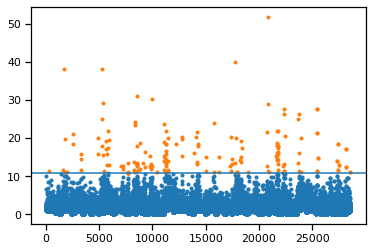

In [95]:
used_data_points = ~((qMRI_data_collapsed.Intensity.isin(['iron', 'myelin'])) & (qMRI_data_collapsed.ROI.isin(['3V', '4V', 'LV']))) & ~(qMRI_data_collapsed.Intensity.isin(['qpd'])) & ~(qMRI_data_collapsed.Measure == 'Voxels')
plt.plot(qMRI_data_collapsed.loc[(used_data_points) & ~(qMRI_data_collapsed.mahalanobis_exclude), 'mahalanobis_d'], '.')
plt.plot(qMRI_data_collapsed.loc[(used_data_points) & (qMRI_data_collapsed.mahalanobis_exclude), 'mahalanobis_d'], '.')
plt.axhline(chi2.ppf(.999, 1))

print('Excluded {} of {} datapoints ({:.5f}%) based on Mahalanobis\nExcluded {} of {} datapoints ({:.5f}%) based on Cooks'.format(qMRI_data_collapsed.loc[used_data_points].mahalanobis_exclude.sum(), used_data_points.sum(), qMRI_data_collapsed.loc[used_data_points].mahalanobis_exclude.mean(),
     qMRI_data_collapsed.loc[used_data_points].high_cook.sum(), used_data_points.sum(), qMRI_data_collapsed.loc[used_data_points].high_cook.mean()))
# 0.72% of all data points

In [89]:
qMRI_data_collapsed.loc[used_data_points].high_cook.sum() - qMRI_data_collapsed.loc[used_data_points].mahalanobis_exclude.sum()

35

## Extract measure of "amount of change"
Here, we take the mean of the absolute derivative. We normalize it by dividing by the models' prediction at 19 year old

In [26]:
def get_mean_change(result, relative=True, sex='both', get_msre=False):
    age_range = np.arange(19, 76)
    
    predict_df_0 = pd.DataFrame({'Age': age_range, 'Age2': age_range**2, 'sex': 0})
    predict_df_1 = pd.DataFrame({'Age': age_range, 'Age2': age_range**2, 'sex': 1})
    
    all_predictions_1 = np.abs(np.diff(result.predict(predict_df_1))).sum() * np.sign(np.diff(result.predict(predict_df_1)).sum())
    if relative:
        all_predictions_1 /= result.predict(predict_df_1)[0]
    all_predictions_0 = np.abs(np.diff(result.predict(predict_df_0))).sum() * np.sign(np.diff(result.predict(predict_df_0)).sum())
    if relative:
        all_predictions_0 /= result.predict(predict_df_0)[0]
    
    pred_at_19 = np.mean([result.predict(predict_df_1)[0], result.predict(predict_df_0)[0]])
    
    if get_msre:
        if result.params.shape[0] == 1 or (result.params.shape[0] == 2 and result.params.index[1] == 'sex'):
            # intercept only model, ignore MSRE (not required for plot)
            return 0
        else:
            # get rescaled MSE. First, rescale data by dividing by the model's prediction at 19 years old
            rescaled_data = result._results.model.endog/pred_at_19

            # Rescale predictions of real data
            rescaled_predictions = result.predict()/pred_at_19

            # SSE
            rescaled_sse = np.sum((rescaled_data-rescaled_predictions)**2)
            rescaled_mse_red = rescaled_sse/result._results.model._df_resid
            return rescaled_mse_red
    
    elif sex == 'both':
        return np.mean([all_predictions_0, all_predictions_1])
    elif sex == 0:
        return all_predictions_0
    elif sex == 1:
        return all_predictions_1
    else:
        return 1


In [27]:
for abs_rel in ['absolute', 'proportional']:
    for sex in ['f', 'm']:
        winning_model_df['mean_derivative'] = winning_model_df['result'].apply(get_mean_change, relative=(abs_rel=='proportional'), sex=(sex=='m'))
        summary_table = winning_model_df.loc[winning_model_df.qMRI.isin(['iron', 'myelin', 'thickness', 'volume'])].sort_values(['Statistic', 'ROI', 'qMRI']).set_index(['Statistic', 'ROI', 'qMRI'])[['mean_derivative']]
        final_table = summary_table.reset_index()[['qMRI', 'ROI', 'Statistic', 'mean_derivative']].pivot_table(index='ROI', columns=['qMRI', 'Statistic']).round(3)
        final_table.columns = final_table.columns.droplevel(0)
        final_table.to_pickle(f'../data/interim_data/summary_table_qmri_{abs_rel}_{sex}.pkl')
    
    # average across sex
    winning_model_df['mean_derivative'] = winning_model_df['result'].apply(get_mean_change, relative=(abs_rel=='proportional'))
    summary_table = winning_model_df.loc[winning_model_df.qMRI.isin(['iron', 'myelin', 'thickness', 'volume'])].sort_values(['Statistic', 'ROI', 'qMRI']).set_index(['Statistic', 'ROI', 'qMRI'])[['mean_derivative']]
    final_table = summary_table.reset_index()[['qMRI', 'ROI', 'Statistic', 'mean_derivative']].pivot_table(index='ROI', columns=['qMRI', 'Statistic']).round(3)
    final_table.columns = final_table.columns.droplevel(0)
    final_table.to_pickle(f'../data/interim_data/summary_table_qmri_{abs_rel}.pkl')


# # Proportional, only F
# winning_model_df['mean_derivative'] = winning_model_df['result'].apply(get_mean_change, relative=True, sex=0)
# summary_table = winning_model_df.loc[winning_model_df.qMRI.isin(['iron', 'myelin', 'thickness', 'volume'])].sort_values(['Statistic', 'ROI', 'qMRI']).set_index(['Statistic', 'ROI', 'qMRI'])[['mean_derivative']]
# final_table = summary_table.reset_index()[['qMRI', 'ROI', 'Statistic', 'mean_derivative']].pivot_table(index='ROI', columns=['qMRI', 'Statistic']).round(3)
# final_table.columns = final_table.columns.droplevel(0)
# final_table.to_pickle('../data/interim_data/summary_table_qmri_proportional_f.pkl')

# # proportional, only M
# winning_model_df['mean_derivative'] = winning_model_df['result'].apply(get_mean_change, relative=True, sex=1)
# summary_table = winning_model_df.loc[winning_model_df.qMRI.isin(['iron', 'myelin', 'thickness', 'volume'])].sort_values(['Statistic', 'ROI', 'qMRI']).set_index(['Statistic', 'ROI', 'qMRI'])[['mean_derivative']]
# final_table = summary_table.reset_index()[['qMRI', 'ROI', 'Statistic', 'mean_derivative']].pivot_table(index='ROI', columns=['qMRI', 'Statistic']).round(3)
# final_table.columns = final_table.columns.droplevel(0)
# final_table.to_pickle('../data/interim_data/summary_table_qmri_proportional_m.pkl')


# MSE of residuals after rescaling  # note actually used anymore
# winning_model_df['mean_derivative'] = winning_model_df['result'].apply(get_mean_change, relative=True, sex=0, get_msre=True)
# summary_table = winning_model_df.loc[winning_model_df.qMRI.isin(['iron', 'myelin', 'thickness', 'volume'])].sort_values(['Statistic', 'ROI', 'qMRI']).set_index(['Statistic', 'ROI', 'qMRI'])[['mean_derivative']]
# final_table = summary_table.reset_index()[['qMRI', 'ROI', 'Statistic', 'mean_derivative']].pivot_table(index='ROI', columns=['qMRI', 'Statistic']).round(3)
# final_table.columns = final_table.columns.droplevel(0)
# final_table.to_pickle('../data/interim_data/summary_table_qmri_rescaled_msres.pkl')


# # Absolute
# winning_model_df['mean_derivative'] = winning_model_df['result'].apply(get_mean_change, relative=False)
# summary_table = winning_model_df.loc[winning_model_df.qMRI.isin(['iron', 'myelin', 'thickness', 'volume'])].sort_values(['Statistic', 'ROI', 'qMRI']).set_index(['Statistic', 'ROI', 'qMRI'])[['mean_derivative']]
# final_table = summary_table.reset_index()[['qMRI', 'ROI', 'Statistic', 'mean_derivative']].pivot_table(index='ROI', columns=['qMRI', 'Statistic']).round(3)
# final_table.columns = final_table.columns.droplevel(0)
# final_table.to_pickle('../data/interim_data/summary_table_qmri_absolute.pkl')


# # Proportional
# winning_model_df['mean_derivative'] = winning_model_df['result'].apply(get_mean_change, relative=True)
# summary_table = winning_model_df.loc[winning_model_df.qMRI.isin(['iron', 'myelin', 'thickness', 'volume'])].sort_values(['Statistic', 'ROI', 'qMRI']).set_index(['Statistic', 'ROI', 'qMRI'])[['mean_derivative']]
# final_table = summary_table.reset_index()[['qMRI', 'ROI', 'Statistic', 'mean_derivative']].pivot_table(index='ROI', columns=['qMRI', 'Statistic']).round(3)
# final_table.columns = final_table.columns.droplevel(0)
# final_table.to_pickle('../data/interim_data/summary_table_qmri_proportional.pkl')

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


## Bootstrapping

To get standard errors of the absolute change metrics, we bootstrap. For each fit model, do the following 10,000 times:
- Take a random sample with replacement of all data points (same size as data);
- Make sure there are at least 5 observations within each age decade from 30-40, 40-50, 50-60, 60-70, to ensure the bootstrapped sample still represents the entire age range
- Re-fit the winning model;
- Estimate the absolute change metric

to obtain standard errors, take the mean of all estimated absolute change metrics.

In [28]:
winning_model_df = pd.read_pickle('../code/app/subcortex-app/data/winning_models/qmri_age_models.pkl')

In [29]:
def check_ages_are_good(ages):
    if (ages < 30).sum() < 10:
        return False
    if ((ages >= 30) & (ages < 40)).sum() < 10:
        return False
    if ((ages >= 40) & (ages < 50)).sum() < 10:
        return False
    if ((ages >= 50) & (ages < 60)).sum() < 10:
        return False
    if ((ages >= 60) & (ages < 70)).sum() < 10:
        return False
    if (ages >= 70).sum() < 10:
        return False
    return True

In [30]:
def get_balanced_sample(data):
    return pd.concat([data.loc[data.Age<30].sample(frac=1, replace=True),
                       data.loc[(data.Age>=30) & (data.Age<40)].sample(frac=1, replace=True),
                       data.loc[(data.Age>=40) & (data.Age<50)].sample(frac=1, replace=True),
                       data.loc[(data.Age>=50) & (data.Age<60)].sample(frac=1, replace=True),
                       data.loc[(data.Age>=60) & (data.Age<70)].sample(frac=1, replace=True),
                       data.loc[(data.Age>=70)].sample(frac=1, replace=True)])


In [31]:
def do_bootstrap(model, n_iter=1000, enforce_balanced_ages=True):
    outcomes = {'absolute_mean_change': np.empty(n_iter),
                'relative_mean_change': np.empty(n_iter),
                'absolute_mean_change_m': np.empty(n_iter),
                'absolute_mean_change_f': np.empty(n_iter),
                'relative_mean_change_m': np.empty(n_iter),
                'relative_mean_change_f': np.empty(n_iter),
                }
    data = model.data.frame.copy()  # extract data from model; excluded data points are not in here
    formula = model.formula
    if not ('Age' in formula or 'Age2' in formula):
        outcomes['absolute_mean_change'] = [0,0,0,0]
        outcomes['relative_mean_change'] = [0,0,0,0]
        outcomes['absolute_mean_change_m'] = [0,0,0,0]
        outcomes['absolute_mean_change_f'] = [0,0,0,0]
        outcomes['relative_mean_change_m'] = [0,0,0,0]
        outcomes['relative_mean_change_f'] = [0,0,0,0]
    else:
        for i in range(n_iter):
    #    for i in range(n_iter):
    #         if i % 100 == 0:
    #             print(i)
            if enforce_balanced_ages:
                this_sample = get_balanced_sample(data)
            else:
                this_sample = data.sample(frac=1, replace=True)
                
            new_model = smf.ols(formula, this_sample)
            results = new_model.fit()

            outcomes['absolute_mean_change'][i] = get_mean_change(results, relative=False)
            outcomes['relative_mean_change'][i] = get_mean_change(results, relative=True)
            outcomes['absolute_mean_change_m'][i] = get_mean_change(results, relative=False, sex=1)
            outcomes['absolute_mean_change_f'][i] = get_mean_change(results, relative=False, sex=0)
            outcomes['relative_mean_change_m'][i] = get_mean_change(results, relative=True, sex=1)
            outcomes['relative_mean_change_f'][i] = get_mean_change(results, relative=True, sex=0)
    return outcomes

def get_SE_CI(outcomes):
    out = {}
    for key,val in outcomes.items():
        if key != 'n_samples_rejected':
            out[key] = {'CI': [np.percentile(val, 2.5), np.percentile(val, 97.5)],
                        'SE': np.std(val),
                        'mean': np.mean(val),
                        'median': np.median(val)}
    return out

def get_errors(i, winning_model_df, n_iter=10000, enforce_balanced_ages=True):
    model = winning_model_df.iloc[i]['model']
    
    new_row = winning_model_df.iloc[i].copy()
    new_row['bootstrap_results'] = get_SE_CI(do_bootstrap(model, n_iter=n_iter, enforce_balanced_ages=enforce_balanced_ages))
    return new_row

In [32]:
# import joblib
# from functools import partial
# from joblib import delayed


# for n_iter in [100, 1000, 10000]:
#     print(n_iter)
#     all_out = joblib.Parallel(n_jobs=10, verbose=1)(delayed(get_errors)(i, winning_model_df=winning_model_df, n_iter=n_iter, enforce_balanced_ages=True) for i in range(winning_model_df.shape[0]))
#     all_bootstrapped_res = pd.DataFrame(all_out)
#     all_bootstrapped_res.to_pickle(f'../data/bootstraps/all_bootstrapped_data_n={n_iter}_balanced.pkl')

In [ ]:
import joblib
from functools import partial
from joblib import delayed


for n_iter in [100, 1000, 10000]:
    print(n_iter)
    all_out = joblib.Parallel(n_jobs=10, verbose=1)(delayed(get_errors)(i, winning_model_df=winning_model_df, n_iter=n_iter, enforce_balanced_ages=False) for i in range(winning_model_df.shape[0]))
    all_bootstrapped_res = pd.DataFrame(all_out)
    all_bootstrapped_res.to_pickle(f'../data/bootstraps/all_bootstrapped_data_n={n_iter}.pkl')

100


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   42.9s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  3.8min
[Parallel(n_jobs=10)]: Done 272 out of 272 | elapsed:  5.8min finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


1000


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  6.1min


## Old stuff
"Normalize" by value at 19yo

In [ ]:
# def plot_fit_normalized(combination, df, winning_model_df, model_df, dep_var_name='Value',
#                         fn_template='./figures_quadratic/modality-{}_statistic-{}_excl-high-cooks-norm.pdf'):
#     intensity, statistic = combination
#     print(intensity)
    
#     pdf = PdfPages(fn_template.format(intensity, statistic))
#     f, ax = plt.subplots(5,4, sharey=False)
#     ax = ax.ravel()

#     # select from dataframes
#     this_df = df.loc[(df.Intensity == intensity) & (df.Statistic == statistic)]
#     this_winning_model_df = winning_model_df.loc[(winning_model_df.qMRI == intensity) & (winning_model_df.Statistic == statistic)]
#     this_model_df = model_df.loc[(model_df.qMRI == intensity) & (model_df.Statistic == statistic)]

#     plot_model_fit_norm(df=this_df,
#                         winning_model_df=this_winning_model_df, dep_var_name=dep_var_name,
#                         intensity=intensity, statistic=statistic, f=f, ax=ax)
#     pdf.savefig(f)
#     pdf.close()

# def plot_model_fit_norm(df, winning_model_df, statistic='', intensity='', f=None, ax=None, shape=(5,4),
#                        dep_var_name='Value'):
#     if ax is None:
#         f, ax = plt.subplots(shape[0], shape[1], sharey=True)
#         ax = ax.ravel()
    
#     age_range = np.arange(19, 81)
#     predict_df_0 = pd.DataFrame({'Age': age_range, 'Age2': age_range**2, 'sex': 0})
#     predict_df_1 = pd.DataFrame({'Age': age_range, 'Age2': age_range**2, 'sex': 1})
    
#     for i, roi in enumerate(df.ROI.unique()):
#         idx = (df.ROI == roi) & (df.Intensity == intensity) & (df.Statistic == statistic)

#         this_df = df.loc[idx, [dep_var_name] + ['Age', 'Age2', 'sex']]
#         if 'high_cook' in df.columns:
#             this_df['is_outlier'] = df.loc[idx, 'high_cook'].values.copy().astype(int)
#         else:
#             this_df['is_outlier'] = 0
#         ax[i].axhline(y=0, linestyle='--', color='black')

#         # Get model fit
#         model_df_idx = (winning_model_df.ROI == roi) & (winning_model_df.qMRI == intensity) & (winning_model_df.Statistic == statistic)
#         if model_df_idx.sum() > 0:
#             result = winning_model_df.loc[model_df_idx, 'result'].values[0]

#             predicted_0 = result.predict(predict_df_0) # sex = 0
#             predicted_1 = result.predict(predict_df_1) # sex = 1
#         pred_intercept_19yo = np.mean([predicted_0[0], predicted_1[0]])
#         this_df.loc[idx, dep_var_name] /= pred_intercept_19yo
        
#         ## non-outliers
#         ax[i].plot(this_df.loc[(idx) & (this_df['sex']==0) & (this_df['is_outlier']==0), 'Age'], this_df.loc[(idx) & (this_df['sex']==0) & (this_df['is_outlier']==0), dep_var_name], '.', c='red', label='F data')
#         ax[i].plot(this_df.loc[(idx) & (this_df['sex']==1) & (this_df['is_outlier']==0), 'Age'], this_df.loc[(idx) & (this_df['sex']==1) & (this_df['is_outlier']==0), dep_var_name], '.', c='blue', label='M data')

#         ## outliers
#         ax[i].plot(this_df.loc[(idx) & (this_df['sex']==0) & (this_df['is_outlier']==1), 'Age'], this_df.loc[(idx) & (this_df['sex']==0) & (this_df['is_outlier']==1), dep_var_name], 'x', c='red', label='F outlier')
#         ax[i].plot(this_df.loc[(idx) & (this_df['sex']==1) & (this_df['is_outlier']==1), 'Age'], this_df.loc[(idx) & (this_df['sex']==1) & (this_df['is_outlier']==1), dep_var_name], 'x', c='blue', label='M outlier')
#         ax[i].set_ylabel(intensity)
#         ax[i].set_xlabel('Age')
#         ax[i].set_title(roi)

#         # plot winning model
#         model_df_idx = (winning_model_df.ROI == roi) & (winning_model_df.qMRI == intensity) & (winning_model_df.Statistic == statistic)
#         if model_df_idx.sum() > 0:
#             result = winning_model_df.loc[model_df_idx, 'result'].values[0]

#             predicted_0 = result.predict(predict_df_0) # sex = 0
#             predicted_1 = result.predict(predict_df_1) # sex = 1
#             predicted_0 /= pred_intercept_19yo
#             predicted_1 /= pred_intercept_19yo
            
#             ax[i].plot(age_range, predicted_0, '-', label='F model', c='red')
#             ax[i].plot(age_range, predicted_1, '-', label='M model', c='blue')

#             # add text indicating the winning model. Apply a "trick" plot an empty line with the winning model as the label
#             tmp = ax[i].plot(np.NaN, np.NaN, '-', color='none', label=winning_model_df.loc[model_df_idx, 'ivs'].values[0])
#             handles, labels = ax[i].get_legend_handles_labels()
#             ax[i].legend(handles[-1:], labels[-1:])

#     # add a legend
#     handles, labels = ax[i].get_legend_handles_labels()
#     f.legend(handles[:-1], labels[:-1], loc='right')   # skip first (dots) and last (label) index
#     f.suptitle('{} {}'.format(statistic, intensity), fontsize=24)
            
#     # add shared axis labels
#     f.add_subplot(111, frame_on=False)
#     plt.tick_params(labelcolor="none", bottom=False, left=False)
#     plt.xlabel("Age")

#     # increase size, tight layout so labels dont overlap, add some space at the top & left so title fits
#     f.set_size_inches(15, 15)
#     f.tight_layout()
#     f.subplots_adjust(top=0.95, right=.9)

#     return f, ax

# # df = qMRI_data_collapsed.copy()
# # # plot_model_fit(df.loc[(df.Intensity == 'iron') & (df.Statistic == 'median')],
# # #                winning_model_df.loc[(winning_model_df.qMRI == 'iron') & (winning_model_df.Statistic == 'median')],
# # #                intensity='iron', statistic='median')


# # plot_fit_normalized(('iron', 'median'), df=qMRI_data_collapsed.copy(), 
# #                       winning_model_df=winning_model_df, model_df=model_df, 
# #                       fn_template='../figures_quadratic/modality-{}_statistic-{}_excl-high-cooks-norm.pdf')
# # #          list(itertools.product(('iron', 'myelin', 'r1hz', 'r2hz', 'qsm', 'thickness'), ('median', 'iqr'))

In [ ]:
# with mp.Pool(12) as p:
#     p.map(partial(plot_fit_normalized, df=qMRI_data_collapsed.copy(), 
#                   winning_model_df=winning_model_df, model_df=model_df, 
#                   fn_template='../figures_quadratic/modality-{}_statistic-{}_excl-high-cooks_norm.pdf'), 
#           list(itertools.product(('iron', 'myelin', 'r1hz', 'r2hz', 'qsm', 'thickness'), ('median', 'iqr'))))

In [ ]:
# # plot & save
# sns.set_context('notebook')
# df = qMRI_data_collapsed.copy()

# for intensity in ['iron', 'myelin', 'r1hz', 'r2hz', 'qsm', 'thickness']:
#     for statistic in ['median', 'iqr']:
#         print('{} {}'.format(statistic, intensity))
#         pdf = PdfPages('./figures_quadratic/modality-{}_statistic-{}_excl-high-cooks.pdf'.format(intensity, statistic))
#         f, ax = plt.subplots(5,4, sharey=True)
#         ax = ax.ravel()
        
#         # select from dataframes
#         this_df = df.loc[(df.Intensity == intensity) & (df.Statistic == statistic)]
#         this_winning_model_df = winning_model_df.loc[(winning_model_df.qMRI == intensity) & (winning_model_df.Statistic == statistic)]
#         this_model_df = model_df.loc[(model_df.qMRI == intensity) & (model_df.Statistic == statistic)]
        
#         plot_model_fit(df=this_df,
#                        winning_model_df=this_winning_model_df,
#                        intensity=intensity, statistic=statistic, f=f, ax=ax)
#         pdf.savefig(f)
        
#         for plot_type in ['index', 'influence']:
#             f, ax = plt.subplots(5,4, sharey=True)
#             ax = ax.ravel()
#             plot_influence(df=this_df, winning_model_df=this_winning_model_df, influence_type=plot_type, f=f, ax=ax)
#             pdf.savefig(f)

#         for studentized in [False, True]:
#             f, ax = plt.subplots(5,4, sharey=True)
#             ax = ax.ravel()
#             plot_residuals(df=this_df, 
#                            winning_model_df=this_winning_model_df, 
#                            model_df=this_model_df, studentized=studentized,
#                            f=f, ax=ax)
#             pdf.savefig(f)
    
#         pdf.close()
#         plt.close('all')  ## force close, don't show in-line

## For presentation

In [ ]:
# import matplotlib.patheffects as pe
# def plot_model_fit_talk(df, winning_model_df, statistic='', intensity='', f=None, ax=None, shape=(4,4)):
#     if ax is None:
#         f, ax = plt.subplots(shape[0], shape[1], sharey=True)
#         ax = ax.ravel()
    
#     ax = ax.ravel()
    
#     age_range = np.arange(19, 81)
#     predict_df_0 = pd.DataFrame({'Age': age_range, 'Age2': age_range**2, 'Age3': age_range**3, 'Age4': age_range**4, 'sex': 0})
#     predict_df_1 = pd.DataFrame({'Age': age_range, 'Age2': age_range**2, 'Age3': age_range**3, 'Age4': age_range**4, 'sex': 1})
    
#     for i, roi in enumerate(df.ROI.unique()):
#         idx = (df.ROI == roi) & (df.Intensity == intensity) & (df.Statistic == statistic)

#         this_df = df.loc[idx, ['Value', 'Age', 'Age2', 'Age3', 'Age4', 'sex']]
# #        this_df['is_outlier'] = 0
#         if 'high_cook' in df.columns:
#             this_df['is_outlier'] = df.loc[idx, 'high_cook'].values.copy().astype(int)
#         else:
#             this_df['is_outlier'] = 0
#         ax[i].axhline(y=0, linestyle='--', color='black')

#         ## non-outliers
#         ax[i].plot(this_df.loc[(idx) & (this_df['sex']==0) & (this_df['is_outlier']==0), 'Age'], this_df.loc[(idx) & (this_df['sex']==0) & (this_df['is_outlier']==0), 'Value'], '.', c='red', label='F data')
#         ax[i].plot(this_df.loc[(idx) & (this_df['sex']==1) & (this_df['is_outlier']==0), 'Age'], this_df.loc[(idx) & (this_df['sex']==1) & (this_df['is_outlier']==0), 'Value'], '.', c='blue', label='M data')

#         ## outliers
#         ax[i].plot(this_df.loc[(idx) & (this_df['sex']==0) & (this_df['is_outlier']==1), 'Age'], this_df.loc[(idx) & (this_df['sex']==0) & (this_df['is_outlier']==1), 'Value'], 'x', c='red', label='F outlier')
#         ax[i].plot(this_df.loc[(idx) & (this_df['sex']==1) & (this_df['is_outlier']==1), 'Age'], this_df.loc[(idx) & (this_df['sex']==1) & (this_df['is_outlier']==1), 'Value'], 'x', c='blue', label='M outlier')
#         ax[i].set_ylabel(intensity)
#         ax[i].set_xlabel('Age')
#         ax[i].set_title(roi)

        
#         # plot winning model
#         model_df_idx = (winning_model_df.ROI == roi) & (winning_model_df.qMRI == intensity) & (winning_model_df.Statistic == statistic)
#         if model_df_idx.sum() > 0:
#             result = winning_model_df.loc[model_df_idx, 'result'].values[0]

#             predicted_0 = result.predict(predict_df_0) # sex = 0
#             predicted_1 = result.predict(predict_df_1) # sex = 1

#             ax[i].plot(age_range, predicted_0, '-', label='F model', c='red', lw=2, path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()])
#             ax[i].plot(age_range, predicted_1, '-', label='M model', c='blue', lw=2, path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()])

#             # add text indicating the winning model. Apply a "trick" plot an empty line with the winning model as the label
#             label_ = winning_model_df.loc[model_df_idx, 'ivs'].values[0]
#             label_ = label_.lower().replace('2', '^2').replace('3', '^3').replace('4', '^4')  # use regex...
#             label_ = '$'+label_+'$'
#             tmp = ax[i].plot(np.NaN, np.NaN, '-', color='none', label=label_)
#             handles, labels = ax[i].get_legend_handles_labels()
#             ax[i].legend(handles[-1:], labels[-1:], handlelength=0, handletextpad=0)

#     # add a legend
#     handles, labels = ax[i].get_legend_handles_labels()
#     f.legend(handles[:-1], labels[:-1], bbox_to_anchor=(.97,0.08), loc='lower right')   # skip first (dots) and last (label) index
#     f.suptitle('{} {}'.format(statistic, intensity), fontsize=24)
            
#     # add shared axis labels
#     f.add_subplot(111, frame_on=False)
#     plt.tick_params(labelcolor="none", bottom=False, left=False)
#     plt.xlabel("Age")
#     if intensity == 'iron':
#         plt.ylabel('Iron (ppm)')
#     elif intensity == 'myelin':
#         plt.ylabel('Myelin (%)')
#     elif intensity == 'thickness':
#         plt.ylabel('Thickness (mm)')
#     elif intensity == 'r1hz':
#         plt.ylabel('R1 (1/s)')
#     elif intensity == 'r2hz':
#         plt.ylabel('R2* (1/s)')
#     elif intensity == 'qsm':
#         plt.ylabel('QSM (ppm)')

#     # increase size, tight layout so labels dont overlap, add some space at the top & left so title fits
#     f.set_size_inches(15, 15)
#     f.tight_layout()
#     f.subplots_adjust(top=0.90)#, right=.9)

#     return f, ax


In [ ]:
# # plot & save
# sns.set_context('talk')
# df = qMRI_data_expanded.copy()

# for intensity in ['iron', 'myelin', 'thickness', 'r1hz', 'r2hz', 'qsm']:
#     for statistic in ['median', 'iqr']:
#         print('{} {}'.format(statistic, intensity))
#         pdf = PdfPages('./pres_figs/modality-{}_statistic-{}_excl-high-cooks.pdf'.format(intensity, statistic))
#         f, ax = plt.subplots(3,6, sharey=True, gridspec_kw={'hspace': 0.15, 'wspace':0.1})
        
#         # select from dataframes
#         this_df = df.loc[(df.Intensity == intensity) & (df.Statistic == statistic)]
#         this_winning_model_df = winning_model_df.loc[(winning_model_df.qMRI == intensity) & (winning_model_df.Statistic == statistic)]
#         this_model_df = model_df.loc[(model_df.qMRI == intensity) & (model_df.Statistic == statistic)]
        
#         f, _ = plot_model_fit_talk(df=this_df,
#                                    winning_model_df=this_winning_model_df,
#                                    intensity=intensity, statistic=statistic, f=f, ax=ax)
#         for col in range(0,ax.shape[1]):
#             for row in range(0,ax.shape[0]):
#                 ax[row,col].grid(linestyle='--', color='lightgrey')
#                 if row < 2:
#                     for tic in ax[row,col].xaxis.get_major_ticks():
#                         tic.tick1On = tic.tick2On = False
#                         tic.label1On = tic.label2On = False
#                 ax[row,col].set_ylabel('')
#                 ax[row,col].set_xlabel('')
#         ax[-1,-1].set_axis_off()
#         f.set_size_inches(15, 9)
# #         break
# #     break

#         pdf.savefig(f)
#         pdf.close()
#         plt.close('all')  ## force close, don't show in-line
# #         for plot_type in ['index', 'influence']:
# #             f, ax = plt.subplots(5,4, sharey=True)
# #             ax = ax.ravel()
# #             plot_influence(df=this_df, winning_model_df=this_winning_model_df, influence_type=plot_type, f=f, ax=ax)
# #            pdf.savefig(f)

# #         for studentized in [False, True]:
# #             f, ax = plt.subplots(5,4, sharey=True)
# #             ax = ax.ravel()
# #             plot_residuals(df=this_df, 
# #                            winning_model_df=this_winning_model_df, 
# #                            model_df=this_model_df, studentized=studentized,
# #                            f=f, ax=ax)
# #             pdf.savefig(f)
    
